# Workshop: Introduction Object Detection using YOLO

## 1. Setting Up Kaggle and Downloading Car Plate Detection Dataset
   - Install Kaggle API for dataset download
   - Upload Kaggle API key
   - Download the car plate detection dataset from Kaggle

## 2. Data Preprocessing and YOLO Labeling
   - Load and preprocess the dataset
   - Implement YOLO labeling for object detection
   - Split the data into training and testing sets

## 3. Custom IoU Metric Function
   - Explanation of Intersection over Union (IoU)
   - Implementation of a custom IoU metric function
   - Understanding IoU threshold and its significance

## 4. YOLO-based Object Detection Model Architecture
   - Designing the architecture of a YOLO-based object detection model
   - Explanation of each layer and its purpose
   - Introduction to probability and bounding box prediction

## 5. Train the Model
   - Compilation of the model with custom IoU metric
   - Training the YOLO-based object detection model

## 6. Test the Model
   - Evaluation of the trained model on test data
   - Visualization of model predictions
   - Discussion of results and potential improvements

# 7. Workshop challenge


In [1]:
# install the 'colorama' library for colored terminal text
!pip install colorama
# Install gdown
!pip install gdown

# 1. Setting Up Kaggle and Downloading Car Plate Detection Dataset





In [2]:
# Install Kaggle API for dataset download
!pip install -q kaggle

# Download kaggle.json directly from the shared link using gdown
file_id = '1lWBhd5jbQdMWakb_6AJ2l01OdjjsmoBN'  # Replace with the correct file ID from your shared link
destination_path = '/content/kaggle.json'  # Change the destination path if needed

# Download the file using gdown
!gdown --id $file_id -O $destination_path

# Create a directory for storing Kaggle API key
!mkdir ~/.kaggle

# Move the uploaded Kaggle API key to the appropriate directory
!cp kaggle.json ~/.kaggle/

# Set appropriate permissions for the Kaggle API key
!chmod 600 ~/.kaggle/kaggle.json

# List available datasets on Kaggle
!kaggle datasets list

# Download the car plate detection dataset from Kaggle
!kaggle datasets download -d andrewmvd/car-plate-detection

# Create a directory to store the dataset and unzip the contents
!mkdir train
!unzip car-plate-detection.zip -d train

"""
# Install Kaggle API for dataset download
!pip install -q kaggle

# Upload your Kaggle API key (kaggle.json) file
from google.colab import files
files.upload()

# Create a directory for storing Kaggle API key
!mkdir ~/.kaggle

# Move the uploaded Kaggle API key to the appropriate directory
!cp kaggle.json ~/.kaggle/

# Set appropriate permissions for the Kaggle API key
!chmod 600 ~/.kaggle/kaggle.json

# List available datasets on Kaggle
!kaggle datasets list

# Download the car plate detection dataset from Kaggle
!kaggle datasets download -d andrewmvd/car-plate-detection

# Create a directory to store the dataset and unzip the contents
!mkdir train
!unzip car-plate-detection.zip -d train
"""

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1lWBhd5jbQdMWakb_6AJ2l01OdjjsmoBN
To: /content/kaggle.json
100% 70.0/70.0 [00:00<00:00, 268kB/s]
ref                                                  title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                      DAIGT V2 Train Dataset                      29MB  2023-11-16 01:38:36           3019        252  1.0              
muhammadbinimran/housing-price-prediction-data       Housing Price Prediction Data              763KB  2023-11-21 17:56:32         

'\n# Install Kaggle API for dataset download\n!pip install -q kaggle\n\n# Upload your Kaggle API key (kaggle.json) file\nfrom google.colab import files\nfiles.upload()\n\n# Create a directory for storing Kaggle API key\n!mkdir ~/.kaggle\n\n# Move the uploaded Kaggle API key to the appropriate directory\n!cp kaggle.json ~/.kaggle/\n\n# Set appropriate permissions for the Kaggle API key\n!chmod 600 ~/.kaggle/kaggle.json\n\n# List available datasets on Kaggle\n!kaggle datasets list\n\n# Download the car plate detection dataset from Kaggle\n!kaggle datasets download -d andrewmvd/car-plate-detection\n\n# Create a directory to store the dataset and unzip the contents\n!mkdir train\n!unzip car-plate-detection.zip -d train\n'

In [3]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, backend as K
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from colorama import Fore
import sys

Visualizing an Example Car Image

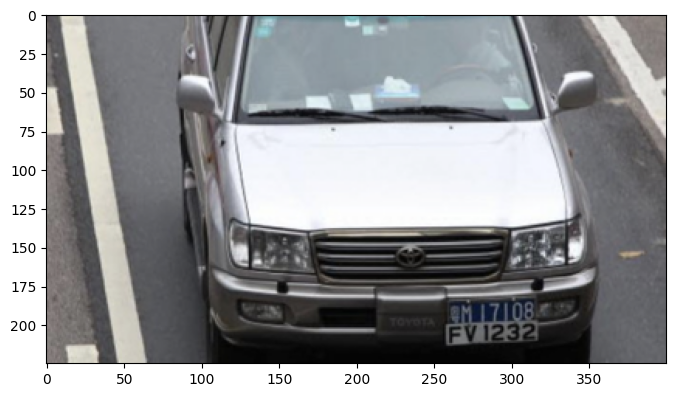

In [4]:
# Set the default figure size for matplotlib
plt.rcParams["figure.figsize"] = (8, 8)

# Create a subplot
plt.subplot(1, 1, 1)

# Specify the path for the example car image (adjust the index as needed)
image_index = 40
image_path = f"train/images/Cars{image_index}.png"

# Load the image using PIL and convert it to a NumPy array
image_array = np.array(Image.open(image_path))

# Display the image using matplotlib
plt.imshow(image_array)

# Show the plot
plt.show()

# 2. Data Preprocessing and YOLO Labeling

# Creating YOLO Labels

## Bounding Box Information Extraction from XML (Annotations):

The dataset includes XML annotation files corresponding to each image. These files contain information about the bounding boxes of objects, specifically cars in this case. The function `get_` is employed to extract specific information such as xmin, ymin, xmax, and ymax from the XML annotations.

## Scaling and Resizing Images:

Images are loaded and converted to the RGB format. Scaling factors (`im_y_scale` and `im_x_scale`) are calculated based on the original image dimensions to normalize pixel values. Subsequently, the images are resized to a standardized size of 256x256 pixels.

## Creating YOLO Labels:

YOLO requires a specific label format to facilitate object detection. This involves dividing the image into a grid, typically a 16x16 grid in this case.

### Understanding the Grid System:

- The image is conceptually divided into a grid of cells.
- Each cell is associated with a specific region of the image.
- For a 16x16 grid, there are 256 cells in total.
- The objective is to predict whether an object is present in each cell and, if so, define the bounding box for that object.

### Assigning Bounding Boxes to Grid Cells:

- Bounding box information extracted from XML annotations is converted to YOLO label format.
- The coordinates of the top-left corner (`x1, y1`) and bottom-right corner (`x2, y2`) of the bounding box are calculated.
- The grid coordinates (`mx, my`) of the cell containing the object's center are determined.

### Probability and Localization:

- A probability value is assigned to each cell, indicating the likelihood of an object being present.
- The x and y coordinates of the bounding box within the cell are calculated to represent the localization of the object.

### Prevention of Duplicated Labels:

- To prevent duplicated labels, it is checked whether a cell already has an assigned label.
- If a label is present, the process skips that cell to avoid redundancy.

These YOLO labels are then stored in the `y_train` array for training the YOLO model. This grid-based approach enhances the model's ability to detect and localize objects efficiently in various regions of the image.


In [5]:
# Function to extract bounding box information from XML
def get_(bndbox, p):
    return int(bndbox.find(p).text)

# Directory path containing the images
directory_path = "train/images/"

# Calculate the actual number of images in the directory
data_size = len([file for file in os.listdir(directory_path) if file.endswith(".png")])

# Initialize arrays to store images and labels
x_train = np.zeros((data_size, 256, 256, 3), dtype=np.float32)
y_train = np.zeros((data_size, 16, 16, 5), dtype=np.float32)

# Define grid size for YOLO labels
grid_size = 16

# Iterate through each image in the dataset with a progress bar
for image_index in tqdm(range(data_size), position=0, leave=True, file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET), desc="Processing Images"):
    # Construct paths for image and annotation files
    image_path = f"train/images/Cars{image_index}.png"
    annotation_path = f"train/annotations/Cars{image_index}.xml"

    # Load the image and convert it to RGB
    image = np.array(Image.open(image_path).convert('RGB'))

    # Calculate scaling factors for resizing
    im_y_scale = 255.0 / image.shape[0]
    im_x_scale = 255.0 / image.shape[1]

    # Resize the image and normalize pixel values
    x_train[image_index, :, :, :] = cv2.resize(image, (256, 256)) / 255.0

    # Extract bounding box information from the XML annotation
    boxes = []
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    for object_ in root.findall('object'):
        for bndbox in object_.findall('bndbox'):
            boxes.append([get_(bndbox, 'xmin'), get_(bndbox, 'ymin'), get_(bndbox, 'xmax'), get_(bndbox, 'ymax')])

    # Convert boxes from image_size to 256*256 size
    boxes = [[boxe[0] * im_x_scale, boxe[1] * im_y_scale, (boxe[2] - boxe[0]) * im_x_scale, (boxe[3] - boxe[1]) * im_y_scale] for boxe in boxes]

    # Process bounding boxes and create YOLO labels
    for boxe in boxes:
        px, py = boxe[0], boxe[1]
        mx, my = int((px + int(boxe[2] / 2)) // grid_size), int((py + int(boxe[3] / 2)) // grid_size)

        # Channels for YOLO labels
        channels = y_train[image_index, :, :, :][my][mx]

        # Prevent duplicated labels
        if channels[0] > 0:
            continue

        # Set YOLO label values
        channels[0] = 1.0  # Probability
        channels[1] = px - (mx * grid_size)  # x1
        channels[2] = py - (my * grid_size)  # y1
        channels[3] = boxe[2]  # x2
        channels[4] = boxe[3]  # y2

# Split the data into training and testing sets
test_size = 0.1
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, random_state=42)


# Show summary of data
print("Data Summary:")
print(f"Total Samples: {data_size}")
print(f"Train Samples: {len(x_train)}")
print(f"Test Samples: {len(x_test)}")
print(f"Image Shape: {x_train.shape[1:]}")
print(f"Label Shape: {y_train.shape[1:]} - Represents a grid of 16x16 cells, where each cell has 5 values: [Probability, x1, y1, x2, y2] for object detection.")


Processing Images: 100%|██████████| 433/433 [00:10<00:00, 42.22it/s]
Data Summary:
Total Samples: 433
Train Samples: 389
Test Samples: 44
Image Shape: (256, 256, 3)
Label Shape: (16, 16, 5) - Represents a grid of 16x16 cells, where each cell has 5 values: [Probability, x1, y1, x2, y2] for object detection.


Visualizing YOLO Predictions with Grid and Probability-based Colors

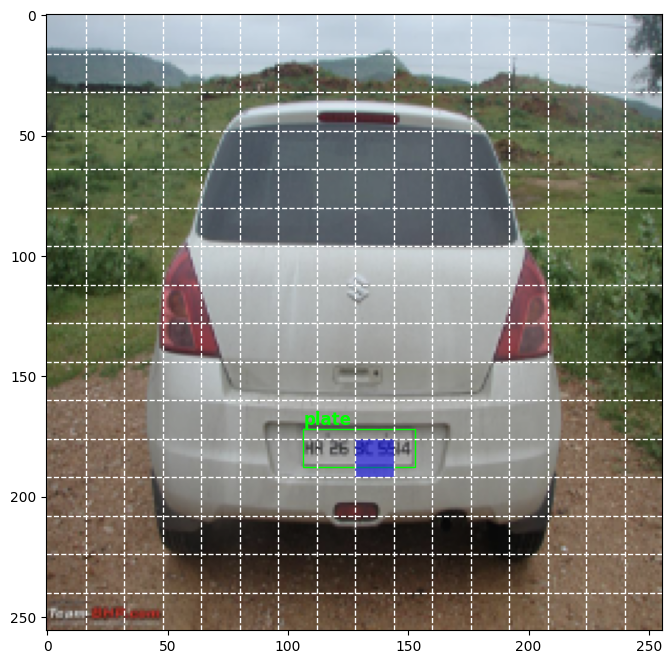

In [6]:
# Function to get color based on probability for visualization
def get_color_by_probability(p):
    if p < 0.3:
        return (1., 0., 0.)
    if p < 0.7:
        return (1., 1., 0.)
    return (0., 1., 0.)

# Function to show predictions
def show_predict(X, y, threshold=0.1, draw_grid=True):
    fig, ax = plt.subplots(1)
    ax.imshow(X)

    if draw_grid:
        # Draw vertical grid lines
        for mx in range(1, 16):
            ax.axvline(mx * grid_size, color='white', linestyle='--', linewidth=1)
        # Draw horizontal grid lines
        for my in range(1, 16):
            ax.axhline(my * grid_size, color='white', linestyle='--', linewidth=1)

    for mx in range(16):
        for my in range(16):
            channels = y[my][mx]
            prob, x1, y1, x2, y2 = channels[:5]

            # If probability is below the threshold, skip
            if prob < threshold:
                continue

            # Get color based on probability
            color = get_color_by_probability(prob)

            # Handle cases where width or height is 0
            width = max(1, x2)
            height = max(1, y2)

            # Draw bounding box
            px, py = (mx * grid_size) + x1, (my * grid_size) + y1

            rect = patches.Rectangle((px, py), width, height, linewidth=1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            if draw_grid:
                # Colorize the grid with 0.5 transparent blue
                grid_rect = patches.Rectangle((mx * grid_size, my * grid_size), grid_size, grid_size, linewidth=1, edgecolor='none', facecolor=(0, 0, 1, 0.5))
                ax.add_patch(grid_rect)

            # Draw label using text with adjusted text thickness
            class_name = "plate"
            label_text = f'{class_name}'
            plt.text(px, py , label_text, color=color, fontsize=12, fontweight='bold', ha='left', va='bottom')

    plt.show()

index = 40
show_predict(x_train[index], y_train[index])

# 3. Custom IoU Metric Function

![Custom IoU Metric](https://drive.google.com/uc?export=view&id=1DQfHuWHqXNIzLNvOEdjyHpTGxst4Rfv7)

## Objective:
The Custom IoU (Intersection over Union) metric is designed to evaluate the accuracy of object detection predictions. IoU measures the overlap between predicted bounding boxes and ground truth bounding boxes. Let's break down the key concepts step by step.

## Input Parameters:
- `y_true`: Ground truth labels representing actual object locations.
- `y_pred`: Predicted labels generated by the model.
- `threshold`: IoU threshold for considering a prediction as correct (default is 0.5).

## Reshaping Labels:
- The ground truth (`y_true`) and predicted labels (`y_pred`) are reshaped to facilitate computation.
- Each label is reshaped into a 4D tensor with dimensions (batch_size, 16, 16, 5), where 16x16 represents the grid cells and 5 represents the YOLO label components (probability, x, y, width, height).

## Extracting Box Information:
- The x, y, width, and height components are extracted from both ground truth and predicted labels.

## Calculating Overlaps:
- The function computes the overlaps in the x and y dimensions between true and predicted bounding boxes.
- It calculates the intersection and union areas based on these overlaps.

## Computing IoU:
- IoU is calculated as the ratio of the intersection area to the union area, considering a small epsilon to avoid division by zero.

## Applying Threshold and Probability:
- A binary mask is created based on the IoU exceeding the specified threshold and the ground truth probability being greater than or equal to 0.5.

## Weighted IoU Calculation:
- The final step involves calculating the weighted mean IoU, considering only the relevant bounding boxes that meet the threshold and probability criteria.
- The result is normalized by the batch size.

## Conclusion:
The Custom IoU Metric function provides a comprehensive evaluation of the model's ability to accurately predict object locations, considering both spatial overlap and confidence in predictions.




In [7]:
# Custom IoU metric function with threshold and probability
def iou_metric(y_true, y_pred, threshold=0.5):
    """
    Calculate Intersection over Union (IoU) as a custom metric.

    Parameters:
    - y_true: Ground truth labels.
    - y_pred: Predicted labels.
    - threshold: IoU threshold for considering a prediction as correct.

    Returns:
    - IoU: Intersection over Union.
    """
    box_true = K.reshape(y_true, (-1, 16, 16, 5))
    box_pred = K.reshape(y_pred, (-1, 16, 16, 5))

    true_box = box_true[:, :, :, 1:]
    pred_box = box_pred[:, :, :, 1:]

    true_prob = box_true[:, :, :, 0]
    pred_prob = box_pred[:, :, :, 0]

    x_true, y_true, w_true, h_true = tf.split(true_box, 4, axis=-1)
    x_pred, y_pred, w_pred, h_pred = tf.split(pred_box, 4, axis=-1)

    w_overlap = K.maximum(0.0, K.minimum(x_true + w_true, x_pred + w_pred) - K.maximum(x_true, x_pred))
    h_overlap = K.maximum(0.0, K.minimum(y_true + h_true, y_pred + h_pred) - K.maximum(y_true, y_pred))

    intersection = w_overlap * h_overlap
    union = w_true * h_true + w_pred * h_pred - intersection

    iou = intersection / (union + K.epsilon())  # Avoid division by zero

    # Squeeze the extra dimension in iou
    iou = K.squeeze(iou, axis=-1)

    # Apply threshold and consider probability
    mask = (iou >= threshold) & (true_prob >= 0.5)

    # Calculate mean IoU
    weighted_iou = K.sum(K.sum(iou * K.cast(mask, dtype=tf.float32), axis=[1, 2]) / (K.sum(K.cast(mask, dtype=tf.float32), axis=[1, 2]) + K.epsilon())) / K.cast(K.shape(y_true)[0], dtype=tf.float32)

    return weighted_iou


# 4. YOLO-based Object Detection Model Architecture

![Custom IoU Metric](https://drive.google.com/uc?export=view&id=1tieErxdqXtMw0XSr-ZvV34NdgoVfE65H)

## Objective:
This section defines the architecture of a YOLO-based object detection model for predicting object probabilities and bounding box coordinates.

## Model Architecture:
The model comprises a series of convolutional layers with Leaky ReLU activation, batch normalization, and downsampling to capture hierarchical features at different scales. The final output consists of a probability map and bounding box coordinates.

### Architecture Details:
1. **Input Layer:**
   - Shape: (256, 256, 3)

2. **Feature Extraction Blocks:**
   - Conv2D (16 filters, kernel_size=3, LeakyReLU activation, strides=2)
   - BatchNormalization
   - Conv2D (32 filters, kernel_size=3, LeakyReLU activation)
   - BatchNormalization
   - Conv2D (64 filters, kernel_size=3, LeakyReLU activation, strides=2)
   - BatchNormalization
   - Conv2D (128 filters, kernel_size=3, LeakyReLU activation, strides=2)
   - BatchNormalization
   - Conv2D (256 filters, kernel_size=3, LeakyReLU activation, strides=2)
   - BatchNormalization

3. **Prediction Heads:**
   - `x_prob`: Conv2D layer with 1 filter, kernel_size=3, sigmoid activation for probability prediction.
   - `x_boxes`: Conv2D layer with 4 filters, kernel_size=3 for bounding box coordinates prediction.

4. **Gate Operation:**
   - Utilizes a threshold gate (0.5) on `x_prob` to activate or deactivate bounding box predictions.

5. **Concatenation:**
   - Concatenates the probability map (`x_prob`) and adjusted bounding box predictions (`x_boxes`).

## Loss Functions:
- Two distinct loss functions are defined for probability and bounding box predictions.
- Mean Squared Error (MSE) is used for bounding box predictions.
- Binary Crossentropy is used for probability predictions.
- Overall loss combines both probability and bounding box losses.

## Training Configuration:
- Optimizer: Adam with a learning rate of 0.003.
- Metrics: Custom Intersection over Union (IoU) metric is used for model evaluation.




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         4640      ['batch_normalization[0][0

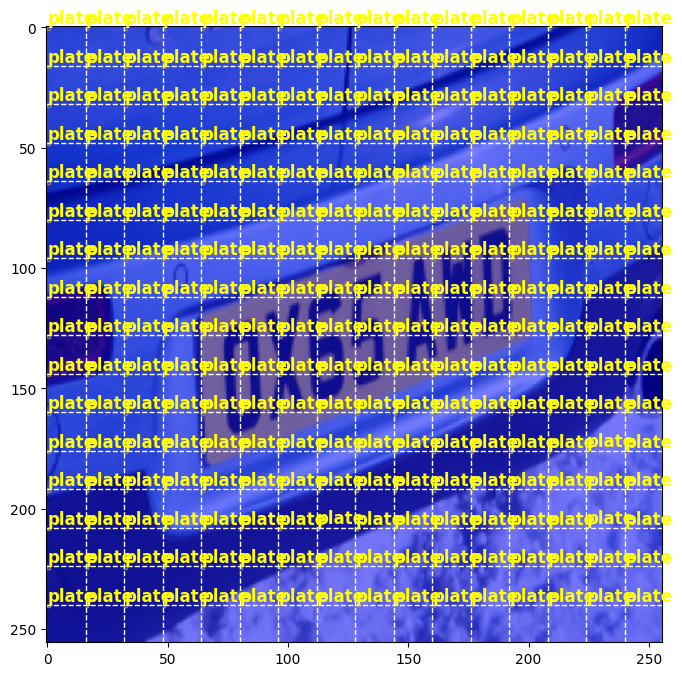

In [8]:
# Input layer definition
x = x_input = layers.Input(shape=(256, 256, 3))

# First convolutional block
x = layers.Conv2D(16, kernel_size=3, padding='same', activation='LeakyReLU', strides=2)(x)
x = layers.BatchNormalization()(x)  # size: 128x128

# Second convolutional block
x = layers.Conv2D(32, kernel_size=3, padding='same', activation='LeakyReLU')(x)
x = layers.BatchNormalization()(x)  # size: 128x128

# Third convolutional block
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='LeakyReLU', strides=2)(x)
x = layers.BatchNormalization()(x)  # size: 64x64

# Fourth convolutional block
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='LeakyReLU', strides=2)(x)
x = layers.BatchNormalization()(x)  # size: 32x32

# Fifth convolutional block
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='LeakyReLU', strides=2)(x)
x = layers.BatchNormalization()(x)  # size: 16x16 = grid_size

# Separate prediction heads for probability and bounding boxes
x_prob = layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid', name='x_prob')(x)
x_boxes = layers.Conv2D(4, kernel_size=3, padding='same', name='x_boxes')(x)

# Apply threshold gate to probability predictions
gate = tf.where(x_prob > 0.5, tf.ones_like(x_prob), tf.zeros_like(x_prob))
x_boxes = x_boxes * gate

# Concatenate probability and bounding box predictions
x = layers.Concatenate()([x_prob, x_boxes])

# Indices for probability and bounding box channels
idx_p = [0]
idx_bb = [1, 2, 3, 4]

# Define loss functions
@tf.function
def loss_bb(y_true, y_pred):
    y_true = tf.gather(y_true, idx_bb, axis=-1)
    y_pred = tf.gather(y_pred, idx_bb, axis=-1)
    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.reduce_mean(loss[loss > 0.0])

@tf.function
def loss_p(y_true, y_pred):
    y_true = tf.gather(y_true, idx_p, axis=-1)
    y_pred = tf.gather(y_pred, idx_p, axis=-1)
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_func(y_true, y_pred):
    # Combined loss function for probability and bounding boxes
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred)

# Create and compile the model
model = tf.keras.models.Model(x_input, x)
model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=loss_func, optimizer=opt, metrics=[iou_metric])

# Function to preview model predictions
def preview(numbers=None, threshold=0.1):
    X = (x_train[0])[np.newaxis, :, :, :]
    y = model.predict(X, verbose=0)
    show_predict(X[0], y[0], threshold=threshold)

preview()

# 5. Train the model

In [ ]:
# Batch size and number of epochs
batch_size = 64
epochs = 300

# Train the model using the specified batch size, epochs, and validation data
model.fit(x_train,
          y_train,
          batch_size=batch_size,  #
          epochs=epochs,
          shuffle=True,  # Shuffle the training data at the beginning of each epoch
          validation_data=(x_test, y_test))  # Validation data to monitor model performance during training

# save the model
model.save("last_plate_detection_model.h5")

Epoch 1/300
7/7 [==============================] - 17s 415ms/step - loss: 29048.7324 - iou_metric: 0.0000e+00 - val_loss: 2968.5945 - val_iou_metric: 0.0000e+00
Epoch 2/300
7/7 [==============================] - 1s 103ms/step - loss: 10381.3984 - iou_metric: 0.0000e+00 - val_loss: 3328.5908 - val_iou_metric: 0.0000e+00
Epoch 3/300
7/7 [==============================] - 1s 103ms/step - loss: 6005.2524 - iou_metric: 0.0000e+00 - val_loss: 5461.8823 - val_iou_metric: 0.0000e+00
Epoch 4/300
7/7 [==============================] - 1s 104ms/step - loss: 3302.4309 - iou_metric: 0.0000e+00 - val_loss: 1732.9374 - val_iou_metric: 0.0000e+00
Epoch 5/300
7/7 [==============================] - 1s 104ms/step - loss: 2261.0566 - iou_metric: 0.0000e+00 - val_loss: 1627.7827 - val_iou_metric: 0.0000e+00
Epoch 6/300
7/7 [==============================] - 1s 104ms/step - loss: 2222.5354 - iou_metric: 0.0000e+00 - val_loss: 1527.7974 - val_iou_metric: 0.0000e+00
Epoch 7/300
7/7 [==========================

# 6. Test the model

In [ ]:
def preview_all(test_data, model, threshold=0.1):
    for i, X in enumerate(test_data):
        X = X[np.newaxis, :, :, :]
        y = model.predict(X, verbose=0)
        show_predict(X[0], y[0], threshold=threshold)
        if i==21: break

preview_all(x_test, model, threshold=0.1)

# 7. Workshop challenge

# Workshop Challenge: Calculate Grid for Point

## Objective:
The challenge is to implement the `calculate_grid_for_point` function, which takes a point's x and y coordinates along with the grid size and returns the corresponding grid indices.

## Challenge Task:
Write the code for the `calculate_grid_for_point` function to calculate the grid indices based on the given point coordinates and grid size.

## Function Signature:
```python
def calculate_grid_for_point(point_x, point_y, grid_size):
    # Your code here
    pass


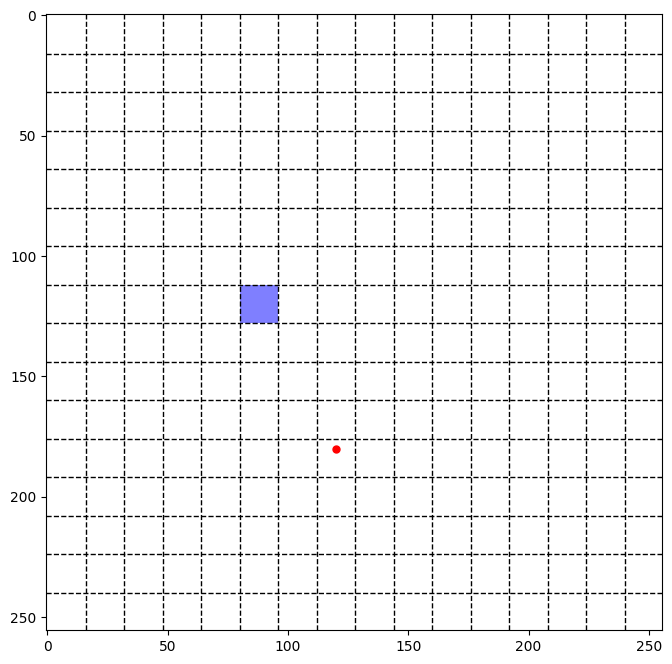

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_grid_and_point(mx, my, grid_size, point_x, point_y):
    # Create a white background image
    X = np.ones((256, 256, 3), dtype=np.uint8) * 255

    fig, ax = plt.subplots(1)
    ax.imshow(X)

    # Draw vertical grid lines
    for gx in range(1, 16):
        ax.axvline(gx * grid_size, color='black', linestyle='--', linewidth=1)
    # Draw horizontal grid lines
    for gy in range(1, 16):
        ax.axhline(gy * grid_size, color='black', linestyle='--', linewidth=1)

    # Colorize the grid with 0.5 transparent blue at the specified grid index
    grid_rect = patches.Rectangle((mx * grid_size, my * grid_size), grid_size, grid_size, linewidth=1, edgecolor='none', facecolor=(0, 0, 1, 0.5))
    ax.add_patch(grid_rect)

    # Draw a point on the image at the specified coordinates
    ax.plot(point_x, point_y, 'ro', markersize=5)

    plt.show()

# Assuming grid_size is defined
point_x = 120
point_y = 180


grid_index_x = 5
grid_index_y = 7

draw_grid_and_point(grid_index_x, grid_index_y, grid_size, point_x, point_y)


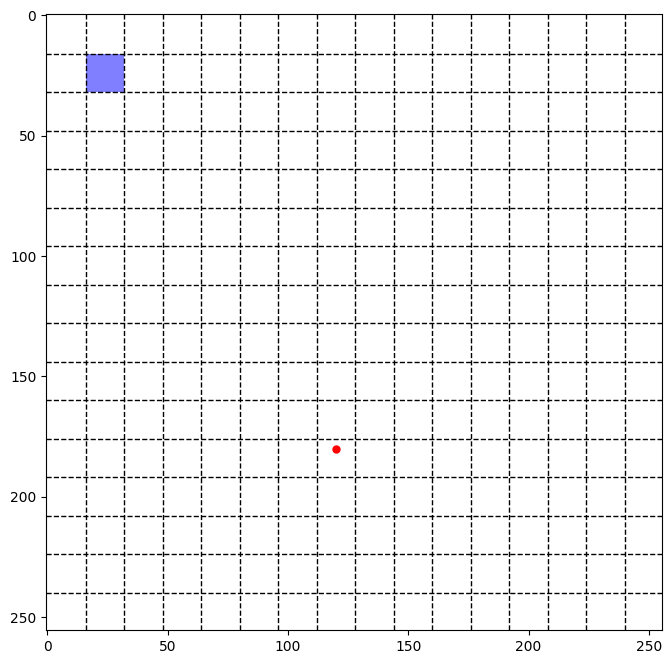

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_grid_and_point(mx, my, grid_size, point_x, point_y):
    # Create a white background image
    X = np.ones((256, 256, 3), dtype=np.uint8) * 255

    fig, ax = plt.subplots(1)
    ax.imshow(X)

    # Draw vertical grid lines
    for gx in range(1, 16):
        ax.axvline(gx * grid_size, color='black', linestyle='--', linewidth=1)
    # Draw horizontal grid lines
    for gy in range(1, 16):
        ax.axhline(gy * grid_size, color='black', linestyle='--', linewidth=1)

    # Colorize the grid with 0.5 transparent blue at the specified grid index
    grid_rect = patches.Rectangle((mx * grid_size, my * grid_size), grid_size, grid_size, linewidth=1, edgecolor='none', facecolor=(0, 0, 1, 0.5))
    ax.add_patch(grid_rect)

    # Draw a point on the image at the specified coordinates
    ax.plot(point_x, point_y, 'ro', markersize=5)

    plt.show()

# Assuming grid_size is defined
point_x = 120
point_y = 180

def calculate_grid_for_point(point_x, point_y, grid_size):
    # Calculate grid indices
    grid_index_x = 1
    grid_index_y = 1

    return grid_index_x, grid_index_y


# Calculate corresponding grid indices
grid_index_x, grid_index_y = calculate_grid_for_point(point_x, point_y, grid_size)

draw_grid_and_point(grid_index_x, grid_index_y, grid_size, point_x, point_y)